# 01 — Data Preparation & EDA

This notebook:
- Loads dataset & config
- Applies the preprocessing pipeline (normalize → tokenize → stopwords)
- Produces quick EDA (doc lengths, top terms)
- Runs lightweight NER frequency analysis


In [1]:
# Ensure local package imports resolve (repo uses src/ layout)
import os, sys
from pathlib import Path

# Adjust this if you run the notebook from elsewhere
REPO_ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
SRC_DIR = REPO_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("Repo root:", REPO_ROOT)
print("Using src dir:", SRC_DIR)

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from escalate_nlp_agent.pipeline import load_raw, preprocess
from escalate_nlp_agent.eda import stats, viz
from escalate_nlp_agent.eda.ner import entity_freq


Repo root: C:\Users\BAB AL SAFA\Documents\Vani\personal\escalate-nlp-agent
Using src dir: C:\Users\BAB AL SAFA\Documents\Vani\personal\escalate-nlp-agent\src


In [ ]:
# Master config: points to a dataset YAML (reuters OR amazon_polarity)
CONFIG_PATH = REPO_ROOT / "configs" / "config.yaml"
with open(CONFIG_PATH, "r") as f:
    cfg = yaml.safe_load(f)

DS_CFG_PATH = REPO_ROOT / cfg["dataset_config"]
with open(DS_CFG_PATH, "r") as f:
    ds_cfg = yaml.safe_load(f)


os.chdir(REPO_ROOT)
print("CWD set to:", os.getcwd())


print("Dataset config:", DS_CFG_PATH)
print("Dataset id:", ds_cfg["id"])

CWD set to: C:\Users\BAB AL SAFA\Documents\Vani\personal\escalate-nlp-agent
Dataset config: C:\Users\BAB AL SAFA\Documents\Vani\personal\escalate-nlp-agent\configs\dataset\reuters.yaml
Dataset id: reuters


In [3]:
# One-time setup (safe to re-run)
import nltk
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

# spaCy small English model for NER (safe to re-run)
import spacy
try:
    _ = spacy.load("en_core_web_sm")
except Exception:
    !python -m spacy download en_core_web_sm


In [4]:
raw_df = load_raw(ds_cfg)
print(f"Raw shape: {raw_df.shape}")
raw_df.head(3)


Raw shape: (10788, 4)


,id,split,text,topics
0,test/14826,test,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,[trade]
1,test/14828,test,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,[grain]
2,test/14829,test,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,"[crude, nat-gas]"


**Column mapping expected (after preprocess):**

- `id` (string)
- `split` (`train` / `test` / `all`)
- `title` (nullable)
- `text` (main text)
- `tokens` (list of tokens) — added by preprocessing
- `meta` (JSON string; dataset-specific)


In [5]:
prep_df = preprocess(raw_df, ds_cfg)
print(f"Preprocessed shape: {prep_df.shape}")
prep_df.head(3)

Preprocessed shape: (10604, 6)


,id,split,title,text,tokens,meta
0,test/14826,test,None,asian exporters fear damage from u.s.-japan ri...,"[asian, exporters, fear, damage, japan, rift, ...",[trade]
1,test/14828,test,None,china daily says vermin eat 7-12 pct grain sto...,"[china, daily, says, vermin, eat, pct, grain, ...",[grain]
2,test/14829,test,None,japan to revise long-term energy demand downwa...,"[japan, revise, long, term, energy, demand, do...","[crude, nat-gas]"


In [6]:
from pathlib import Path

outputs = ds_cfg["outputs"]
interim_path = REPO_ROOT / outputs["interim"]
processed_dir = REPO_ROOT / outputs["processed_dir"]
interim_path.parent.mkdir(parents=True, exist_ok=True)
processed_dir.mkdir(parents=True, exist_ok=True)

prep_df.to_parquet(interim_path, index=False)

for sp in sorted(prep_df["split"].unique()):
    part = prep_df[prep_df["split"] == sp][["id","split","title","text","tokens","meta"]]
    part.to_parquet(processed_dir / f"{sp}.parquet", index=False)

print("Wrote:")
print(" -", interim_path)
for sp in sorted(prep_df["split"].unique()):
    print(" -", f"{sp}.parquet")


Wrote:
 - C:\Users\BAB AL SAFA\Documents\Vani\personal\escalate-nlp-agent\data\interim\reuters\preprocessed.parquet
 - test.parquet
 - train.parquet


Saved: C:\Users\BAB AL SAFA\Documents\Vani\personal\escalate-nlp-agent\reports\figures\reuters_len_hist.png


(-0.5, 639.5, 479.5, -0.5)

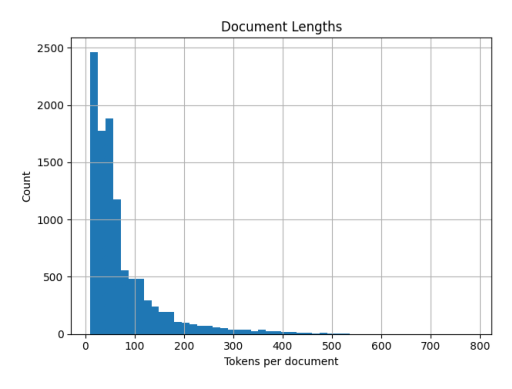

In [7]:
figures_dir = REPO_ROOT / ds_cfg["outputs"]["figures_dir"]
figures_dir.mkdir(parents=True, exist_ok=True)

lengths_df = stats.doc_lengths(prep_df)
out_png = figures_dir / f"{ds_cfg['id']}_len_hist.png"
viz.plot_lengths(lengths_df, out_png)

print("Saved:", out_png)
plt.imshow(plt.imread(out_png))
plt.axis("off")


Saved: C:\Users\BAB AL SAFA\Documents\Vani\personal\escalate-nlp-agent\reports\figures\reuters_top_terms.png


,term,count
0,mln,18569
1,dlrs,12363
2,pct,9729
3,cts,8342
4,year,7157
5,net,6965
6,billion,5763
7,loss,5115
8,shr,4170
9,company,4041


(-0.5, 639.5, 479.5, -0.5)

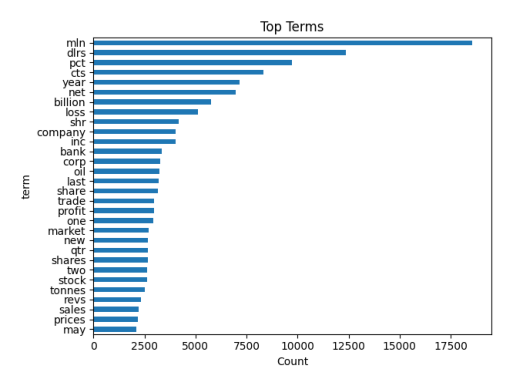

In [8]:
top_n = int(ds_cfg["eda"]["top_terms_n"])
top_df = stats.top_terms(prep_df, n=top_n)
out_png = figures_dir / f"{ds_cfg['id']}_top_terms.png"
viz.plot_top_terms(top_df, out_png)

print("Saved:", out_png)
display(top_df.head(10))
plt.imshow(plt.imread(out_png))
plt.axis("off")


In [9]:
if ds_cfg["eda"]["ner"]["enabled"]:
    limit = int(ds_cfg["eda"]["ner"]["limit"])
    ent_df = entity_freq(prep_df["text"].tolist(), limit=limit)
    out_csv = figures_dir / f"{ds_cfg['id']}_ner_top.csv"
    ent_df.head(100).to_csv(out_csv, index=False)
    print("Saved:", out_csv)
    display(ent_df.head(20))
else:
    print("NER disabled in config.")


Saved: C:\Users\BAB AL SAFA\Documents\Vani\personal\escalate-nlp-agent\reports\figures\reuters_ner_top.csv


,label,text,count
380,ORG,cts,1253
0,GPE,u.s.,935
1,GPE,japan,401
50,DATE,1986,340
53,DATE,today,261
58,DATE,1987,210
9,DATE,last year,181
186,ORG,ec,171
94,ORG,fed,161
24,DATE,yesterday,155


## Next Steps
- Run **extraction** (rule-based + spaCy NER) on processed data:
  - `scripts/run_extraction.py --dataset_config configs/dataset/<dataset>.yaml --extract_config configs/extract/rule_based.yaml`
  - `scripts/run_extraction.py --dataset_config configs/dataset/<dataset>.yaml --extract_config configs/extract/spacy_ner.yaml`

- Run **summarization** (extractive TextRank):
  - `scripts/run_summarization.py --dataset_config configs/dataset/<dataset>.yaml --summarize_config configs/summarize/textrank.yaml`

- Try the **agent demo**:
  - `scripts/run_agent_demo.py --dataset_config configs/dataset/<dataset>.yaml --agent_config configs/agent/news_aggregator.yaml --query "Your question here"`
